In [1]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles


#Probabilistic programs
#!pip install pymc==5.0.2
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
#from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
#from graphviz import Source, Digraph
#import dot2tex as d2t
#from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC v5.0.2


# Model comparison
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

Which model is a better representation of reality?

<center><img src="img/5_CB/starry-night.jpg" width = "800" height = '800'></center>

# Hierarchical models

<center><img src="img/5_CB/Hierarchy.svg" width = "400" height = '400'></center>

Sources: Gelman, et al (2013); Kruschke (2014).

There are many structural jerarquies:
* Probability of survival from COVID 
    * Country. 
        * Hospital.


* Motor cortex activity in economic decisions
    * SMA (supplementary motor area; motor plan)
        * IPS (intraparietal sulcus; accumulation of evidence)
            * vmPFC (ventromedial prefrontal cortex; subjective value)

## First example: Rats tumor

Description: determine $\theta$, the probability of a tumor in lab rats (F344) who do not receive any treatment.

Data: experimental. 71 groups of rats tested before.

Jerarquical model with priors based on previous data. 

In [2]:
#Data
rats = pd.DataFrame(
    np.loadtxt("data/5_CB/rats.asc", skiprows=1), 
    columns = ['y','n']
)
rats.loc[0:20,:] #y: with tumor; n: total rats


,y,n
0,0.0,20.0
1,0.0,20.0
2,0.0,20.0
3,0.0,20.0
4,0.0,20.0
5,0.0,20.0
6,0.0,20.0
7,0.0,19.0
8,0.0,19.0
9,0.0,19.0


71 experiments with j gruops of rats. 

$\theta_j$ is a function of the `hiperparameters` $\alpha, \beta$: 

Hiperparameters reflect group conditions, experiment, or day. <br><br>

<center><img src="img/5_CB/model_rats.svg" width = "801" height = '800'></center>

The distributions for $y_j$ & $\theta_j$:
* Beta support: [0,1], appropriate for proportions.
* Binomial: discrete, for counts.

The distribution $p(\alpha,\beta)$:
* Uniform between $$\left[\frac{\alpha}{\alpha+\beta}, (\alpha+\beta)^{-5/2} \right]$$
* The left is the mean of $\theta_j$
* The right is a function of the denominator of the mean of $\theta_j$: $\alpha + \beta$
* $(\alpha + \beta)^{-5/2}$, is after returning to the original variables (ver Gelman, et al, 2013, Hierarchical Models).

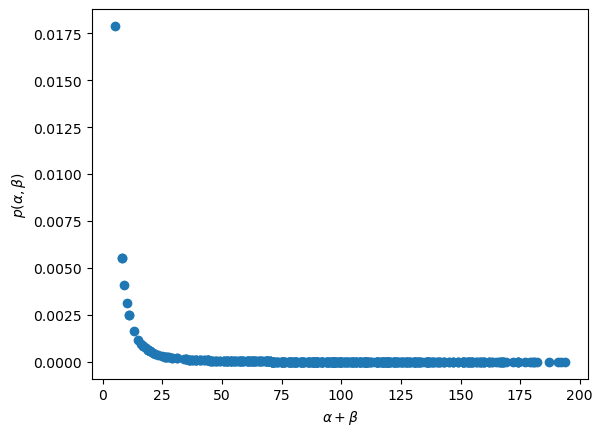

In [3]:
#The prior for alpha and beta punishes high values of alpha+beta
#Punishes mean that it assigns low probabilities
alpha = np.random.randint(0,100,500)
beta = np.random.randint(0,100,500)
y = (alpha+beta)**(-5/2)
plt.scatter(alpha+beta, y);
plt.ylabel('$p(\\alpha,\\beta)$')
plt.xlabel('$\\alpha+\\beta$');

In [36]:
# p(alpha,beta) in log (for the algorithm, to avoid under/over flow)
def logp_ab(a,b):
    return pt.log(pt.pow(a+b, -5/2))
with pm.Model() as model: 
    #Priors
    a = pm.Uniform('alpha', 0.05, 100)
    b = pm.Uniform('beta', 0.05, 100)    
    pm.Potential('p(a, b)', logp_ab(a,b)) 
    #Potential (it is similar to increase_log in STAN)
    #(see Gelman, 2013, Ch 5, ed 3)
    
    theta = pm.Beta('theta', alpha=a, beta=b, 
                    shape=rats.shape[0])
    
    #Likelihoods
    y = pm.Binomial('y', p=theta, n=rats.loc[:,'n'], 
                    observed=rats.loc[:,'y'])
    
    # Sampling
    trace = pm.sample(5000, target_accept=.95)
    #the step size in PyMC is tuned automatically during warm up, 
    #but we can coerce smaller step sizes by tweaking the configuration 
    #of PyMC’s adaptation routine. In particular, we can increase the 
    #target_accept parameter from its default value of 0.8 closer 
    #to its maximum value of 1
    ##posterior_predictive = pm.sample_posterior_predictive(trace)
 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 98 seconds.


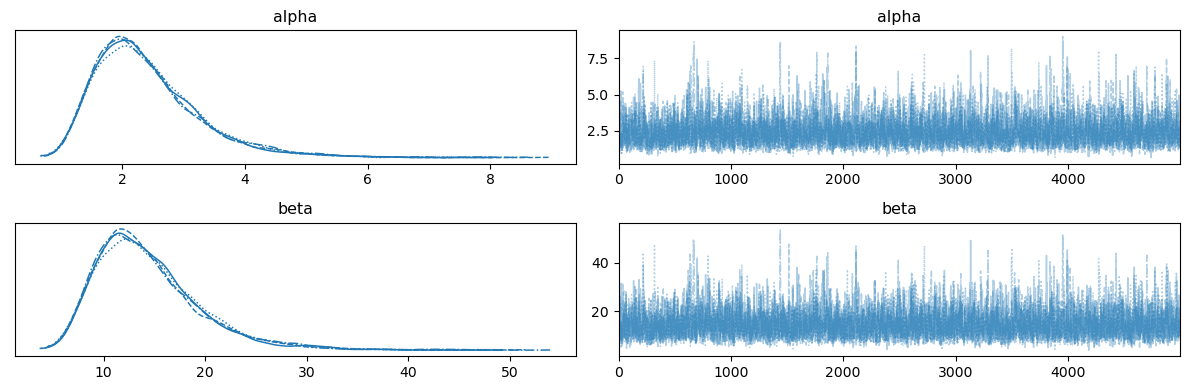

In [37]:
# Mixes well
beta_post = np.array(trace.posterior.beta).flatten()
alpha_post = np.array(trace.posterior.alpha).flatten()
az.plot_trace(trace, var_names=['alpha', 'beta']);
plt.tight_layout()
#plt.savefig('img/5_CB/trace_rats.svg')
#plt.close()

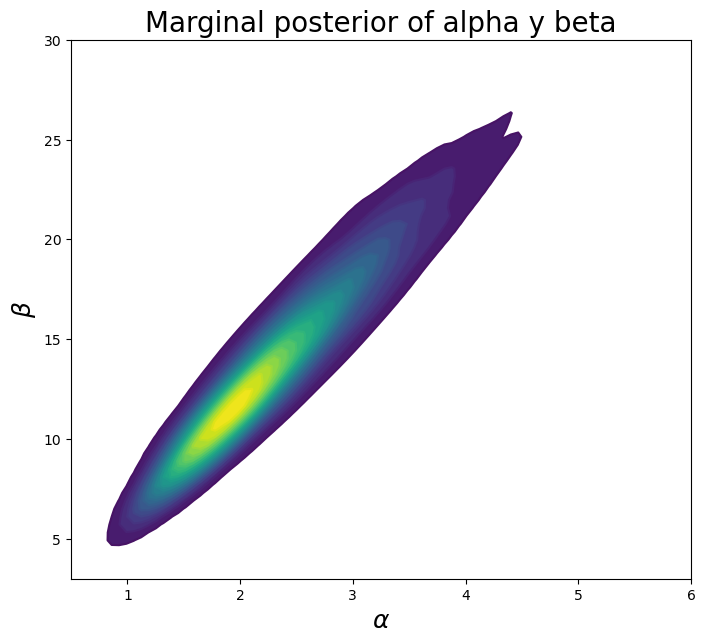

In [38]:
#Posterior of the hyperparameters
fig, ax = plt.subplots(figsize=(8, 7))
az.plot_kde(values=alpha_post, values2=beta_post, 
            ax=ax, contour=True, 
            contour_kwargs={'colors': None, "levels":20,  'cmap': 'viridis'},
            contourf_kwargs={"levels":20})
ax.set_xlim([0.5,6]); ax.set_ylim([3,30]);
plt.xlabel(r'$\alpha$', fontsize = 18)
plt.ylabel(r'$\beta$', fontsize = 18)
plt.title('Marginal posterior of alpha y beta', fontsize = 20);
#fig.savefig('img/5_CB/posterior_rats_ab.svg')
#plt.close()

/var/folders/vw/64n45h3s04q6n36ygp0br_n40000gn/T/ipykernel_82602/2510162365.py:5: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_ = az.hdi(theta_post, hdi_prob=.95)


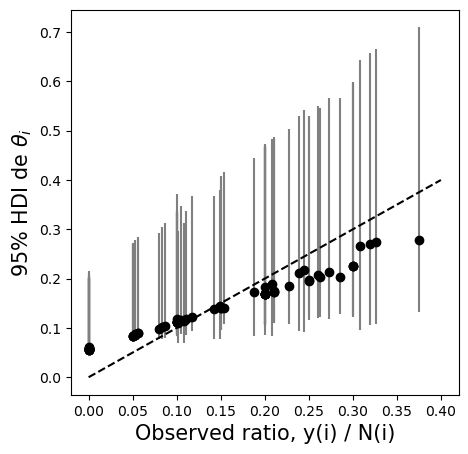

In [39]:
#The model makes good predictions (dotted line)
sh = trace.posterior.theta.shape
theta_post = np.reshape(np.array(trace.posterior.theta), (sh[0]*sh[1], sh[2]))
median_theta = np.median(theta_post, axis=0)
hdi_ = az.hdi(theta_post, hdi_prob=.95)

plt.figure(figsize=(5, 5))
plt.errorbar(rats.loc[:, 'y'] / rats.loc[:, 'n'], median_theta, fmt='o',
             yerr=[hdi_[:,0], hdi_[:,1]], ecolor='gray', 
             markerfacecolor='k', mec='k')
plt.plot(np.linspace(0, .4, 10), np.linspace(0, .4, 10), 'k--')
plt.xlabel('Observed ratio, y(i) / N(i)', fontsize = 15)
plt.ylabel(r'95% HDI de $\theta_i$', fontsize = 15);
#plt.savefig('img/5_CB/posterior2_rats_ab.svg')
#plt.close()

In [40]:
# Comparison between a non-Hierarchical and the Hierarchical model 
x = np.linspace(0, 1, 250)
# binomial likelihood, beta (1,1) prior , 
# resulting posterior is beta(y+1,n-y+1)
# For clarity, just every 7th distribution
theta_sep = st.beta.rvs(a = rats.iloc[0:-1:7,0] + 1, 
                        b = rats.iloc[0:-1:7,1] - rats.iloc[0:-1:7,0] + 1,
                        size = [5000,rats.iloc[0:-1:7,0].shape[0]]) 

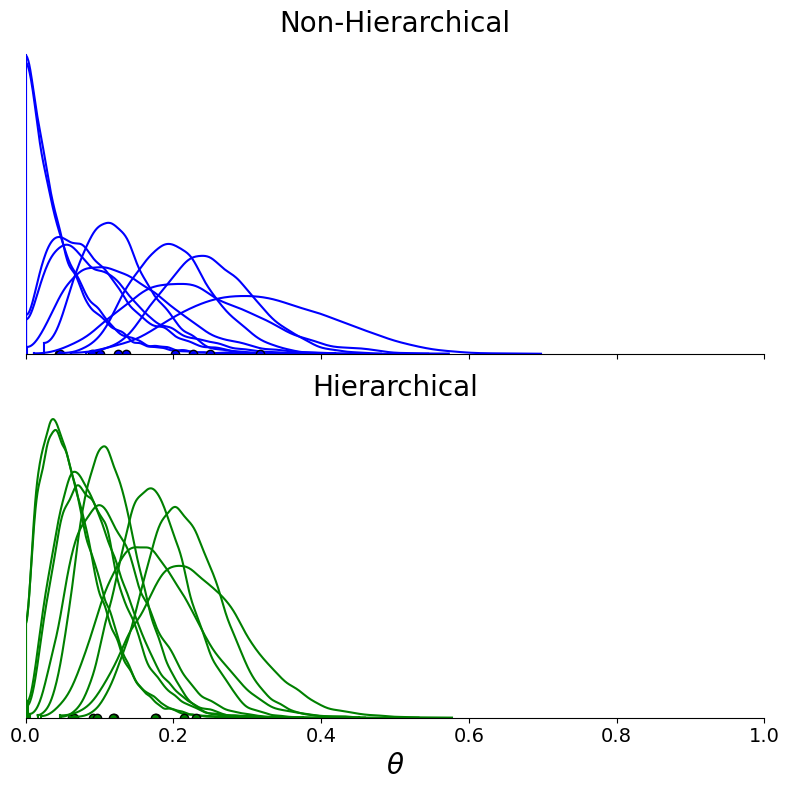

In [41]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
# Non-Hierarchical Model
t = theta_sep
az.plot_density([t[:,0],t[:,1],t[:,2],t[:,3],t[:,4],
                t[:,5],t[:,6],t[:,7],t[:,8],t[:,9]], 
                hdi_prob=1, ax = axes[0], colors = 'blue')
axes[0].set_yticks(())
axes[0].set_title('Non-Hierarchical', fontsize = 20)
axes[0].set_ylim((0, axes[0].set_ylim()[1]))  # set y base to zero
axes[0].set_xlim((0, 1))
axes[0].get_legend().remove()
# Hierarchical Model. Los posteriors para theta_j son
# más angostos que los del modelo separado. El modelo 
# jerárquico toma en cuenta info. de los otros theta_j.
# Por claridad, solo cada 7a distribución
t = theta_post
az.plot_density([t[:,0],t[:,7],t[:,14],t[:,21],t[:,28],
                t[:,35],t[:,42],t[:,49],t[:,56],t[:,63]], 
                hdi_prob=1, ax = axes[1], colors = 'green')
axes[1].set_yticks(())
axes[1].set_xlabel(r'$\theta$', fontsize = 20)
axes[1].set_title('Hierarchical', fontsize = 20)
axes[1].set_ylim((0, axes[1].set_ylim()[1]))
axes[1].set_xlim((0, 1))
axes[1].get_legend().remove()
fig.tight_layout()
#fig.savefig('img/5_CB/posterior3_rats_ab.svg')
#plt.close()

$\theta_j$ are thinner for the jerarquical model. 
That is, there is less uncertainty grouping the experiments via $\alpha$ and $\beta$.
<br> But, which one should we choose? Let's see another example first.

## Second example: eight schools

Problem: Do training programs increase scores in entry-exams to enter universities (e.g. SAT, GRE, SABER)?

Details: 8 schools, each with their own training program.

Data: increase in score (control: each school had a group of student who did not do the training program)

Hierarchical model

<center><img src="img/5_CB/model_8s.svg" width = "800" height = '800'></center>

In [25]:
# SAT-example data (SAT: Scholastic Aptitude Test)
# y is the estimated treatment effect
# s is the standard error of effect estimate
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
s = np.array([15, 10, 16, 11,  9, 11, 10, 18])
schools = pd.DataFrame({"Effect":y, 'SE':s})
schools


,Effect,SE
0,28,15
1,8,10
2,-3,16
3,7,11
4,-1,9
5,1,11
6,18,10
7,12,18


In [42]:
with pm.Model() as model:
    #Priors: top level
    mu = pm.Uniform('mu', 0, 30)
    tau = pm.Uniform('tau', 0, 30)    
    
    #Priors: bottom level
    theta = pm.Normal('theta', mu=mu, sigma=tau, 
                      shape=schools.shape[0])
    
    #Likelihood 
    y = pm.Normal('y', mu = theta, sigma = schools.loc[:,'SE'], 
                  observed = schools.loc[:,'Effect'])
    
    # Sampling
    trace = pm.sample(10000, tune = 1000, target_accept = 0.99)
    posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, theta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 316 seconds.
Sampling: [y]


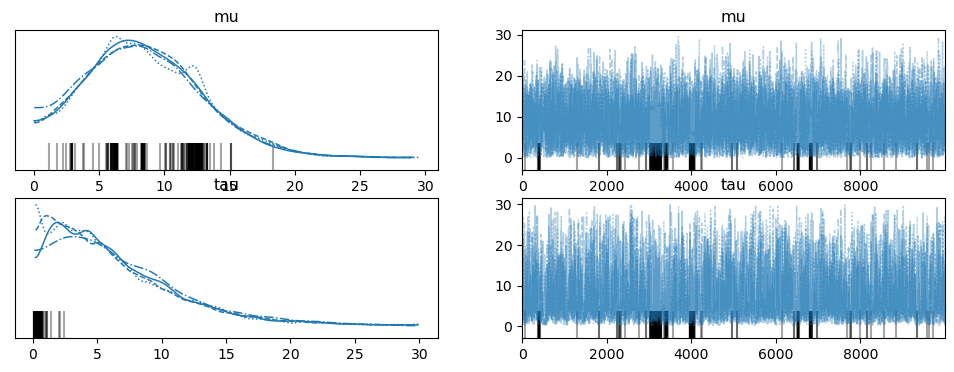

In [43]:
# mixes well
mu_post = np.array(trace.posterior.mu).flatten()
tau_post = np.array(trace.posterior.tau).flatten()
az.plot_trace(trace, var_names=['mu', 'tau']);
#plt.savefig('img/5_CB/trace_8s.svg') 
#plt.close()

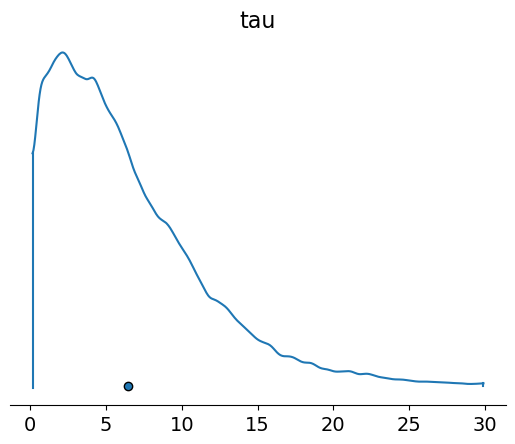

In [44]:
az.plot_density(trace, var_names=['tau'], hdi_prob=1);
#plt.savefig('img/5_CB/density_tau_8s.svg')
#plt.close()

The latent process that gives rise to training effects ($\mu$) is not too noisy ($\tau$)

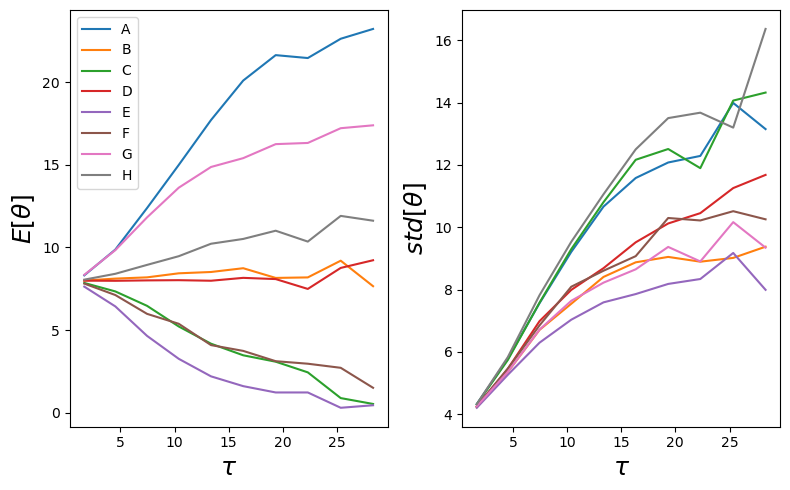

In [45]:
sh = trace.posterior.theta.shape
theta_post = np.reshape(np.array(trace.posterior.theta), (sh[0]*sh[1], sh[2]))
fig, ax = plt.subplots(1,2,figsize=(8,5))
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
for s in range(schools.shape[0]):
    a = np.array([mu_post,
                  tau_post,
                  theta_post[:,s]]).T
    b = a[a[:,1].argsort()] #sorts by the 2nd column
    trace_sorted = pd.DataFrame(b, 
                                columns = ['mu','tau','theta'])
    toplot_mean = trace_sorted.groupby(pd.cut(trace_sorted["tau"], 
                                         bins=10)).mean()
    ax[0].plot(toplot_mean['tau'],toplot_mean['theta'], label = labels[s])
    toplot_std = trace_sorted.groupby(pd.cut(trace_sorted["tau"], 
                                         bins=10)).std()
    ax[1].plot(toplot_mean['tau'],toplot_std['theta'], label = labels[s])
ax[0].set_xlabel(r'$\tau$', fontsize=18)
ax[0].set_ylabel(r'$E[\theta$]', fontsize=18)
ax[1].set_xlabel(r'$\tau$', fontsize=18)
ax[1].set_ylabel(r'$std[\theta]$', fontsize=18)
ax[0].legend();
plt.tight_layout()
#fig.savefig('img/5_CB/tau_theta_8s.svg')
#plt.close()

A strong effect, such as the one observed in school A (28 increase in points), is unlikely (not in the left plot), even with a high hyperparameter $\tau$.


In [46]:
az.summary(trace) #posterior information

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],11.727,8.123,-2.071,28.155,0.092,0.065,7592.0,15303.0,1.00
theta[1],8.183,6.163,-3.259,20.364,0.055,0.040,11866.0,18156.0,1.00
theta[2],6.580,7.433,-7.679,20.838,0.068,0.048,10937.0,15429.0,1.00
theta[3],8.003,6.444,-4.054,20.526,0.057,0.041,11601.0,18054.0,1.00
theta[4],5.468,6.177,-6.769,16.630,0.071,0.050,7408.0,13259.0,1.00
theta[5],6.458,6.539,-6.253,18.709,0.064,0.045,9899.0,17229.0,1.00
theta[6],10.941,6.640,-0.922,23.753,0.078,0.055,7122.0,14689.0,1.00
theta[7],8.800,7.538,-5.236,23.676,0.065,0.051,12126.0,16619.0,1.00
mu,8.496,4.522,0.000,15.949,0.053,0.037,6815.0,7884.0,1.00
tau,6.466,5.015,0.114,15.546,0.110,0.078,1059.0,563.0,1.01


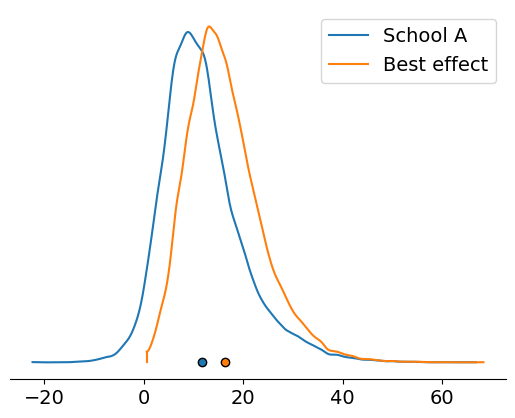

In [47]:
maxx = np.amax(theta_post, axis = 1)
az.plot_density([theta_post[:,0], maxx],
                data_labels=['School A' , 'Best effect'],
                hdi_prob=1);
plt.title("");
#plt.savefig("img/5_CB/AvsMax_8s.svg")
#plt.close()

School A program is good, but weak evidence that it is always the best

In [48]:
# Probability that the school A program is better than 
# the worst program from school C
conteo = np.sum(theta_post[:,0]>theta_post[:,2])
prob = conteo/theta_post.shape[0]
print("Probability that the school A program is better than the worst program from school C: ", np.round(prob,2))


Probability that the school A program is better than the worst program from school C:  0.68


### Exercises (Source: Gelman, et al, 3rd ed.)

1. With the 8 school posterior samples:
    * For each school, estimate the probability that its program is the best.
    * For each pair of schools j,k, estimate the probability that program j is better than program k.    

tip: use np.random.choice

In [ ]:
#Code


2. Repeat point 1 but with a large $\tau$ (this is similar to a non-Hierarchical model). Explain what differences do you see with the results from point 1.


In [20]:
#Code


3. Imagine that you wanted to know the traffic close to your university. With your friends you counted the number of bicycles and other vehicles in 60 blocks during one hour. You chose blocks acording to their activity level (busy, normal, residential) and whether they had bicycle lanes or not. The data is in transit.csv. Work with the first 10 rows, and do the following:
    * A hierarchical model exactly the same as the rat tumor example. Now n is the total number of vehicles (bikes+others). We are interested in the latent propotion of bikes. We want to infer $\theta_j$, the latent proportion of bikes in each block using the available data (first 10 rows of transit.csv).
    * Compare the posterior of $\theta_j$ with the actual observed proportions in each block (#bikes / # bikes + others). Do they differ?
    * Estimate the 95% posterior interval of all $\theta_j$. Not by block, but all $\theta$s. Comment
    * Change the priors and likelihood:
        * Likelihood for the bike counts: $Poisson(\theta_j)$. $\theta_j$ is the mean number of bikes per hour.
        * Prior $Gamma(\alpha,\beta)$ for $\theta_j$. Uniform prior for $\alpha$ and $\beta$
        * Graph this: x-axis: $\alpha$, y-axis: $\beta$)
    
    


In [ ]:
#Code


# Model comparison 

In the previous section we compared data vs. posterior (e.g. rat's tumors). 

Now, let's see way to compare models and pick the best according to a criterion

One approximation is to think the problem as a jerarquical one. <br> 
Two models (m) with different priors and likelihoods. <br> 
The top level has the hyperparameters and we can infer the best ones. 
<center><img src="img/5_CB/Kruschke1.svg" width = "451" height = '450'></center>

Example:
A coin minting company has two production sites.<br>
Site 1: coins are biased towards heads e.g. beta(9,4) <br>
Site 2: coins are biased towards tails e.g. beta(4,9)
<center><img src="img/5_CB/coin.png" width = "351" height = '350'></center>

We look for the posterior probabilities for m=1, m=2 given some coin tosses $y_i$

<center><img src="img/5_CB/Kruschke2.svg" width = "400" height = '400'></center>

In [49]:
#Data
N=9
z=6
y_o = [0]*(N-z) +  [1]*z
y_o

[0, 0, 0, 1, 1, 1, 1, 1, 1]

In [50]:
# Models to compare
m1_info = np.array([3,9])
m2_info = np.array([9,3])
# Inference
with pm.Model() as model:
    #Prior for m (model)
    mi = pm.DiscreteUniform('model_index', lower=0, upper=1)
    
    #Samples from the models to test
    thetaM1 = pm.Beta('thetaM1', m1_info[0], m1_info[1] )
    thetaM2 = pm.Beta('thetaM2', m2_info[0], m2_info[1] )
    
    #Likelihood
    theta = pm.Deterministic('theta', (1-mi)*thetaM1 + (mi)*thetaM2) 
    y = pm.Bernoulli('y', theta, observed = y_o)
    
    #Muestras
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=2000, step = step, start = start)


/var/folders/vw/64n45h3s04q6n36ygp0br_n40000gn/T/ipykernel_82602/3680211072.py:20: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(10000, tune=2000, step = step, start = start)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [model_index]
>Metropolis: [thetaM1]
>Metropolis: [thetaM2]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 47 seconds.


<xarray.Dataset>
Dimensions:      ()
Data variables:
    model_index  float64 1.001
    thetaM1      float64 1.0
    thetaM2      float64 1.001
    theta        float64 1.001

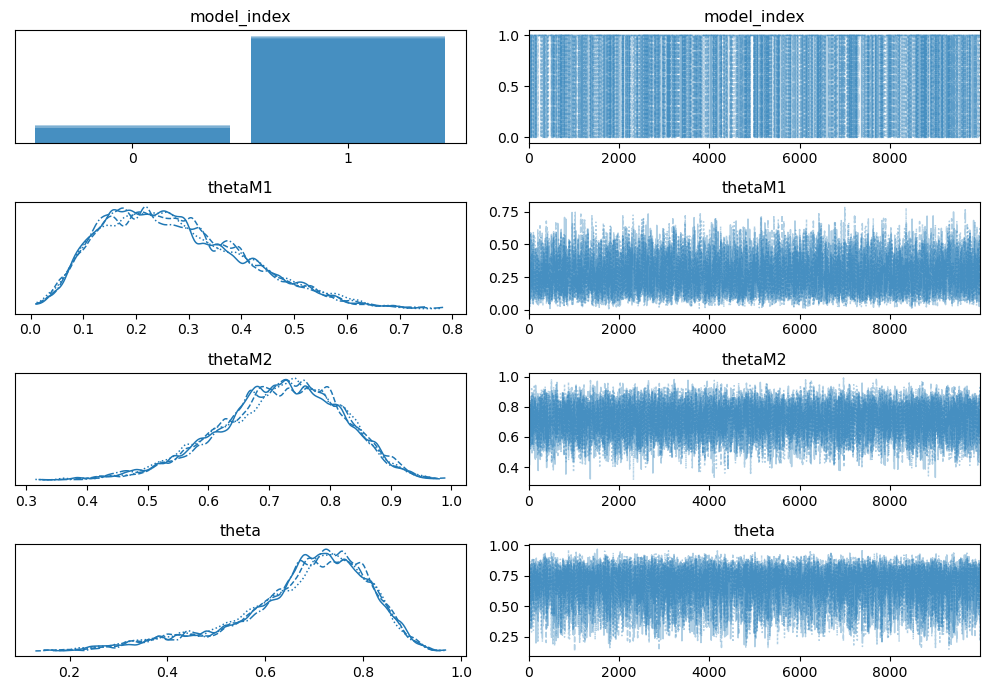

In [52]:
#Convergence
az.plot_trace(trace, figsize = [10,7]);
plt.tight_layout()
#plt.savefig("img/5_CB/trace_model_bern.svg"); plt.close()
az.rhat(trace) #Si es <1.1 está bien

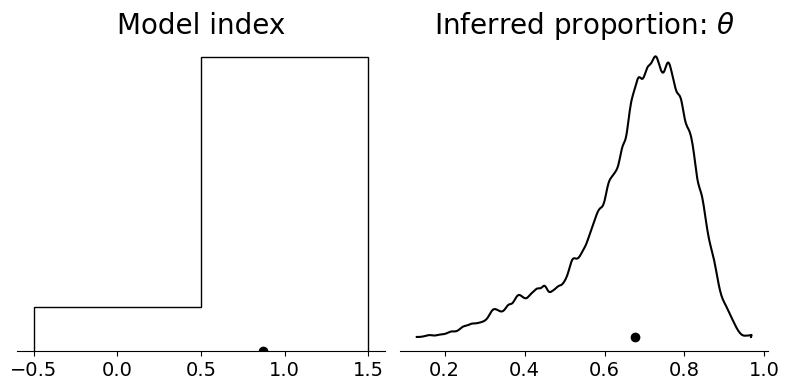

In [53]:
model_index_post = np.array(trace.posterior.model_index).flatten()
theta_post = np.array(trace.posterior.theta).flatten()
fig, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_density(model_index_post, 
                ax = ax[0], colors = 'k')
ax[0].set_title('Model index', fontsize = 20)
az.plot_density(theta_post, 
                ax = ax[1], colors = 'k', hdi_prob=1)
ax[1].set_title(r'Inferred proportion: $\theta$', fontsize = 20);
plt.tight_layout()
#plt.savefig("img/5_CB/density_model_bern.svg"); plt.close()


The model index, suggest that model 2 is better for the data.

In [54]:
print("p(m=2|Data): ", np.round(model_index_post.mean(),4))
print("p(theta|Data): ", np.round(theta_post.mean(),4))
print("Prop. data: ", np.round(z/N,4)) #Data

p(m=2|Data):  0.8697
p(theta|Data):  0.6768
Prop. data:  0.6667


We used different priors ( $\theta_{M1}$, $\theta_{M2}$ ), but the same likelihood. 

We can also use different likelihoods

In [55]:
with model:
    #pm.math.eq(A, B) checks if A==B.
    theta_cond = pm.math.switch(pm.math.eq(mi, 0), 
                                theta, #1er likelihood 
                                2*theta #2do likelihood
                               )
    y_cond = pm.Bernoulli('y_cond', theta_cond, observed = y_o)

## Bayes factor

`Bayes factor` measures how good a model is explaining the data relative to another:

$$BF = \frac{p(Data|Modelo_1)}{p(Data|Modelo_2)}$$

Otra formulación equivalente es (no la vamos a demostrar):

\begin{align}
  BF &= \frac{Post_{odds}}{Prior_{odds}}\\
     &= \frac{\frac{p(Modelo_1|Data)}{p(Modelo_2|Data)}}{\frac{p(Modelo_1)}{p(Modelo_2)}}  
\end{align}






In [56]:
# Bayes factor for the coin example
p_M2 = model_index_post.mean()  
Post_odds = (p_M2)/(1-p_M2)
Prior_odds = 0.5/0.5
BF = Post_odds / Prior_odds # Bayes Factor favors M2
BF

6.673124880107422

This was easy to compute. It is usually not the case. The Bayes Factor is hard because we need the marginal likelihood, which involves complicated integrals. 

## Information Criterion (IC)
Based on  [PyMC website](https://docs.pymc.io/notebooks/model_comparison.html)


Information criterion (IC) are measures to compare models. There are many: BIC, AIC, WAIC. They are based in a function of the likelihood called deviance ([Gelman, et al](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)).  

IMPORTANT: `Models with low IC are better at explaining the data y`. 

This is WAIC:

$$WAIC = -2lppd +2p_{waic}$$

lppd is the log pointwise predictive density (i.e. likelihood). In practice, we use all the S samples from the sampler $\theta^s$. n is the number of data points:
$$computed \; lppd = \sum_{i=1}^n log \left(\frac{1}{S}\sum_{s=1}^S p(y_i|\theta^s)\right)$$

$p_{waic}$ are the effective number of parameters, a term to penalize complex models:

$$p_{waic} = \sum_{i=1}^n V_{s}^S (log(p(y_i|\theta^s))$$ V is variance

Let's see again the 8 schools data:  

Objective: infer the effects of training in universities entry-exams.
<br>Models: 
* Pooled: A single effect for all 8 schools
* Hierarchical: Different effects for each school

Data: 8 effects/gains in scores and standard deviation ($\sigma$)

In [57]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [66]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sigma=1e6)
    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)
    trace_p = pm.sample(2000, idata_kwargs = {'log_likelihood': True})

with pm.Model() as hierarchical:  
    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, sigma=1e6)
    tau = pm.HalfCauchy('tau', 5)
    theta = pm.Deterministic('theta', mu + tau*eta)
    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)
    trace_h = pm.sample(2000, target_accept=0.99, idata_kwargs = {'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.


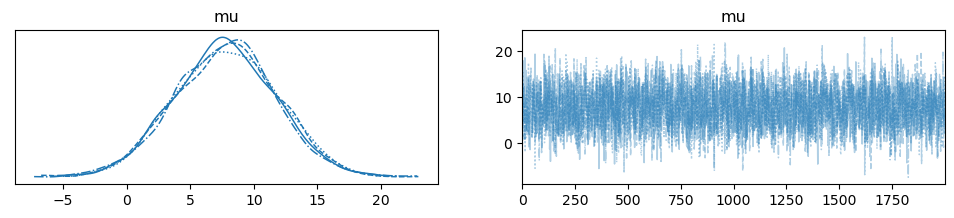

In [67]:
with pooled:
    pm.plot_trace(trace_p, var_names=['mu']);    

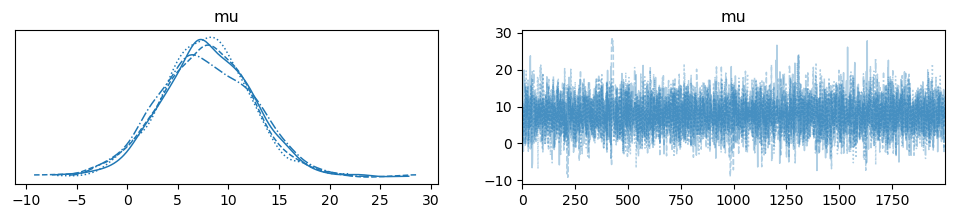

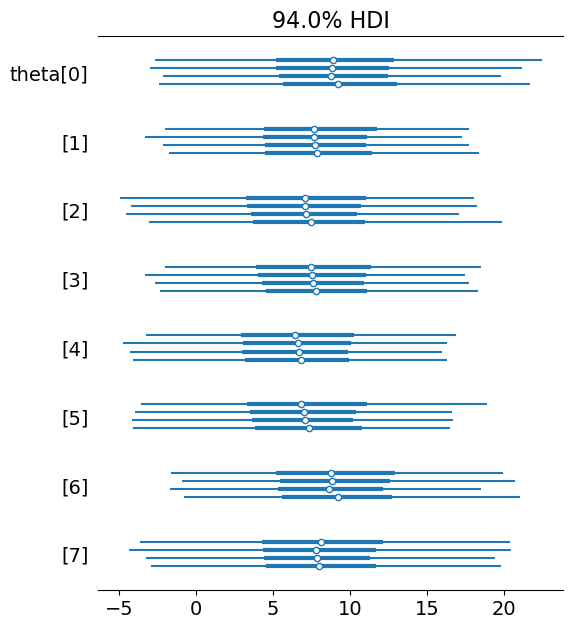

In [68]:
with hierarchical:
    pm.plot_trace(trace_h, var_names=['mu']);
    pm.plot_forest(trace_h, var_names=['theta']); 

PyMC calculates WAIC 

In [70]:
with pooled:
    pooled_waic = pm.waic(trace_p)

with hierarchical:
    hierarchical_waic = pm.waic(trace_h) #this is elpd_waic i.e. waic=-2*elpd_waic
    
print(pooled_waic) 
print(hierarchical_waic)

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.53     1.10
p_waic        0.65        -
Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.76     1.00
p_waic        1.05        -


To compare models

In [71]:
with pooled:
    df_comp_WAIC = pm.compare({'hierarchical': trace_h, 
                               'pooled': trace_p}, ic = 'waic')
    df_comp_loo = pm.compare({'hierarchical': trace_h, 
                              'pooled': trace_p}, ic = 'loo')

In [72]:
display(df_comp_WAIC) # waic
display(df_comp_loo) # leave-one-out cross validation
#rank: order of models, lower rank better (); waic/loo: self-explained but I think it is the elpd_waic
#p_waic: eff. number of parameters; d_waic/d_loo: difference in ...,
#se: of waic/loo; dse: of d_waic/d_loo; warning: should be false

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.526352,0.645062,0.00000,1.0,1.097334,0.000000,False,log
hierarchical,1,-30.763372,1.047165,0.23702,0.0,1.002352,0.108727,False,log


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.542406,0.661116,0.000000,1.000000e+00,1.098227,0.000000,False,log
hierarchical,1,-30.841575,1.125368,0.299169,3.330669e-16,1.002419,0.101453,False,log



Both models are good, the difference in WAIC or loo are too small


# Regressions
Based in Gelman et al y en [Prasad Ostwal](https://ostwalprasad.github.io/machine-learning/Bayesian-Linear-Regression-using-PyMC3.html)

In a traditional regression, we infer the parameters of normal that changes mean according to the values of variables X (assumption, the standard deviation of the normal is fixed):

<center><img src="img/5_CB/Kruschke3.svg" width = "401" height = '400'></center>


$$ y|\beta, \sigma, X \sim Normal(X \beta,\sigma I)$$
$I$ identity; we assume homocedasticity.

The unique thing with bayes is that we can infer $\beta$ and $\sigma$ with `uncertainty`

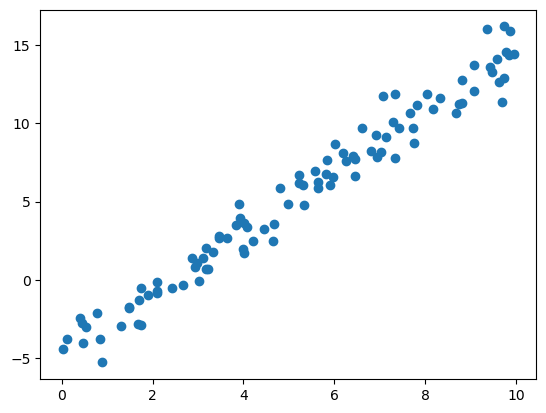

In [73]:
n = 100
x = np.random.uniform(0,10,n)
y = 2 * x - 5 + np.random.normal(0,1,n)
plt.scatter(x, y);

In [74]:
with pm.Model() as basic_model:

    #Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=3)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha + beta*x
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sigma=sigma, observed=y)
    
    # Samples
    trace = pm.sample(draws=3000, idata_kwargs = {'log_likelihood': True}) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 38 seconds.


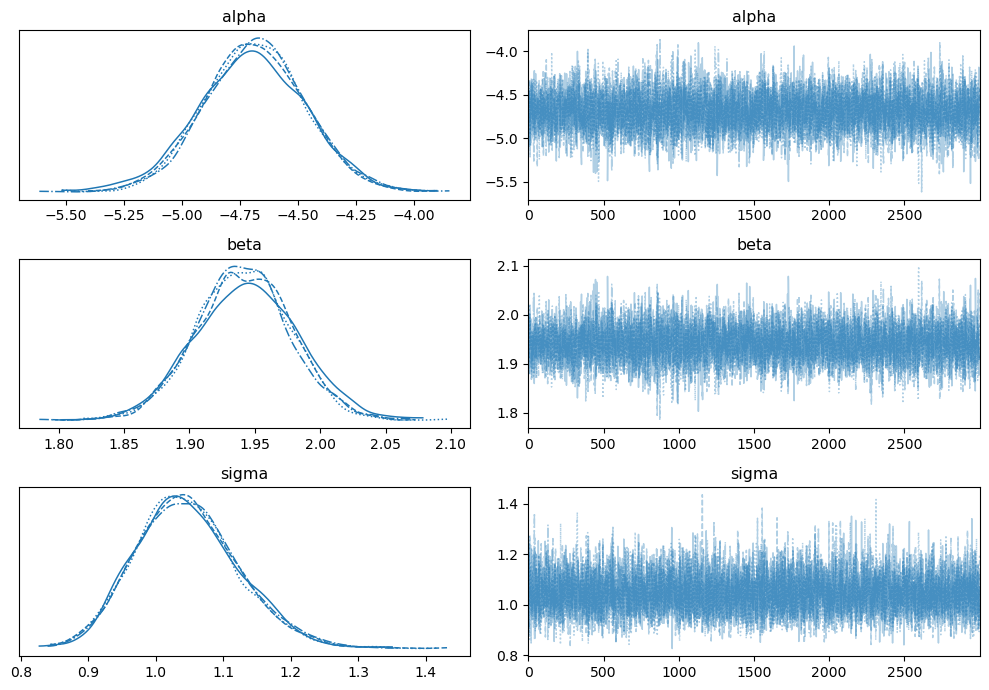

In [75]:
#Convergence
az.plot_trace(trace, figsize = [10,7]);
plt.tight_layout()
#plt.savefig("img/5_CB/trace_regression.svg"); plt.close()
#az.rhat(data) #Si es <1.1 está bien

In [76]:
with basic_model:
    print(pm.summary(trace).round(2))
    #pm.plots.forestplot(trace)

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha -4.69  0.22   -5.10    -4.28        0.0      0.0    5146.0    5137.0   
beta   1.94  0.04    1.87     2.01        0.0      0.0    5081.0    5135.0   
sigma  1.05  0.08    0.90     1.19        0.0      0.0    6665.0    6415.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


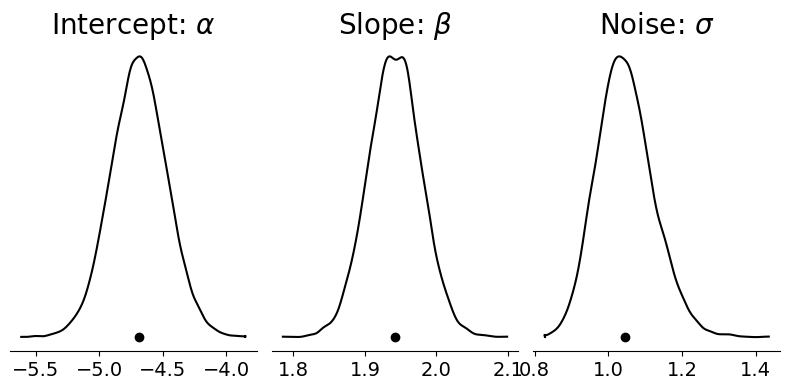

In [77]:
alpha_post = np.array(trace.posterior.alpha).flatten()
beta_post = np.array(trace.posterior.beta).flatten()
sigma_post = np.array(trace.posterior.sigma).flatten()
fig, ax = plt.subplots(1,3, figsize=(8,4))
az.plot_density(alpha_post, 
                ax = ax[0], colors = 'k',hdi_prob=1)
ax[0].set_title(r'Intercept: $\alpha$', fontsize = 20)
az.plot_density(beta_post, 
                ax = ax[1], colors = 'k', hdi_prob=1)
ax[1].set_title(r'Slope: $\beta$', fontsize = 20)
az.plot_density(sigma_post, 
                ax = ax[2], colors = 'k', hdi_prob=1)
ax[2].set_title(r'Noise: $\sigma$', fontsize = 20);
plt.tight_layout()
#plt.savefig("img/5_CB/density_regression.svg"); plt.close()

Is it a good model?. Let's start with posterior predictive checks (i.e. simulate new data). We can use the mean of $y$ in the data to compare.

In [84]:
ypred.posterior_predictive.Ylikelihood.shape

(4, 3000, 100)

In [87]:
with basic_model:
    ypred = pm.sampling.sample_posterior_predictive(trace=trace)
    sh = ypred.posterior_predictive.Ylikelihood.shape
    y_sample_posterior_predictive = np.reshape(np.array(ypred.posterior_predictive.Ylikelihood), 
                                              (sh[0]*sh[1],sh[2]))

Sampling: [Ylikelihood]


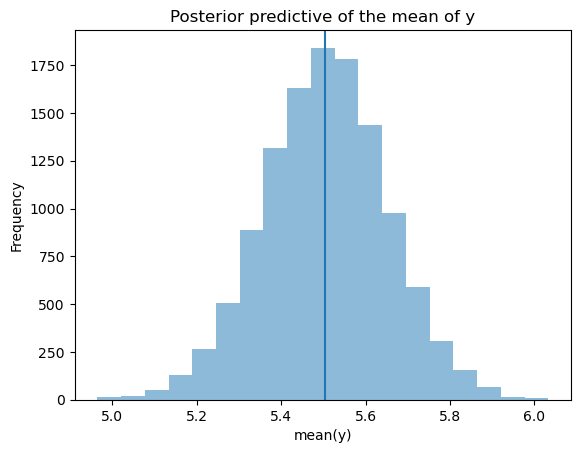

In [88]:
_, ax = plt.subplots()
ax.hist([n.mean() for n in y_sample_posterior_predictive], bins=19, alpha=0.5)
ax.axvline(y.mean()) #actual data
ax.set(title='Posterior predictive of the mean of y', xlabel='mean(y)', ylabel='Frequency');

The posterior predictive check replicates and important stat: the mean of y.

Now let's compare with WAIC the regression with a null regression (just an intercept)

In [90]:
with pm.Model() as null_model:
    #Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=4)

    # Deterministics
    #mu = pm.Deterministic("mu", alpha + beta*x) #to save in trace the deterministic value
    mu = alpha 
    
    # Likelihood 
    Ylikelihood = pm.Normal('Ylikelihood', mu=mu, sigma=sigma, observed=y)
    
    # Samples
    trace_null = pm.sample(draws=3000,  idata_kwargs = {'log_likelihood': True}) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 36 seconds.


In [91]:
with null_model:
    print(pm.summary(trace_null).round(2))

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  5.49  0.57     4.4     6.51        0.0      0.0   12988.0    7891.0   
sigma  5.73  0.40     5.0     6.49        0.0      0.0   13062.0    9465.0   

       r_hat  
alpha    1.0  
sigma    1.0  


In [93]:
az.compare({'Base': trace, 'Null': trace_null}, ic = 'loo')
    

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Base,0,-147.354995,3.234554,0.000000,1.0,7.431511,0.000000,False,log
Null,1,-317.461017,1.433866,170.106022,0.0,4.865163,7.872166,False,log


# Conclusion

There are models that are better at explaining the data.

We can check them with posterior predictive checks or compare them with information criterions (e.g. waic)

There is no perfect model

In [ ]:
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' --SlidesExporter.reveal_scroll=True 5_Model_Comparison.ipynb #Saves slide


Para salvar las diapositivas a PDF (en Chrome), correr nbconvert para que abra las diapositivas en un servidor local (la transition y el theme son opcionales):

!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' nombre_de_mi_notebook.ipynb --post serve

Luego, a la dirección añadirle ?print-pdf después del .html:

http://127.0.0.1:8000/nombre_de_mi_notebook.slides.html?print-pdf

Y luego, imprimir y darle salvar como pdf

In [ ]:
#Para salvar a pdf
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' 5_Model_Comparison.ipynb --post serve

# Anexos

In [ ]:
#Rats
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Rat''s tumor";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.2, width=0.2, lblstyle="font=\\small"];\
           hyperpar -> theta_1; hyperpar -> theta_2; hyperpar -> theta_3;\
           hyperpar -> theta_4; hyperpar -> theta_5; hyperpar -> theta_6;\
           hyperpar -> theta_7; hyperpar -> theta_8; hyperpar -> theta_9;\
           theta_1 -> y_1; theta_2 -> y_2; theta_3 -> y_3; theta_4 -> y_4;\
           theta_5 -> y_5; theta_6 -> y_6; theta_7 -> y_7; theta_8 -> y_8;\
           theta_9 -> y_9;\
           /* nodes */\
           hyperpar [label = "$alpha,beta$"];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           theta_3 [label = "$theta_3$"];\
           theta_4 [label = "$...$"];\
           theta_5 [label = "$...$"];\
           theta_6 [label = "$...$"];\
           theta_7 [label = "$...$"];\
           theta_8 [label = "$theta_{70}$"];\
           theta_9 [label = "$theta_{71}$"];\
           y_1 [label = "$y_1$"];\
           y_2 [label = "$y_2$"];\
           y_3 [label = "$y_3$"];\
           y_4 [label = "$...$"];\
           y_5 [label = "$...$"];\
           y_6 [label = "$...$"];\
           y_7 [label = "$...$"];\
           y_8 [label = "$y_{70}$"];\
           y_9 [label = "$y_{71}$"];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/5_CB/model_rats.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

#alpha_beta_dist [texlbl = "$p(\\alpha,\\beta) \propto  (\\alpha + \\beta)^{-5/2}$", shape = plaintext];\
#theta_dist [texlbl = "$\\theta_j \sim  Beta(\\alpha, \\beta)$", shape = plaintext];\
#y_dist [texlbl = "$y_j \sim  Binomial(n_j, \\theta_j)$", shape = plaintext];\


In [ ]:
# 8 schools
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="8 schools";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.2, width=0.2, lblstyle="font=\\small"];\
           hyperpar -> theta_1; hyperpar -> theta_2; hyperpar -> theta_3;\
           hyperpar -> theta_4; hyperpar -> theta_5; hyperpar -> theta_6;\
           hyperpar -> theta_7; hyperpar -> theta_8;\
           theta_1 -> y_1; theta_2 -> y_2; theta_3 -> y_3; theta_4 -> y_4;\
           theta_5 -> y_5; theta_6 -> y_6; theta_7 -> y_7; theta_8 -> y_8;\
           /* nodes */\
           hyperpar [label = "$mu,tau$"];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           theta_3 [label = "$theta_3$"];\
           theta_4 [label = "$theta_4$"];\
           theta_5 [label = "$theta_5$"];\
           theta_6 [label = "$theta_6$"];\
           theta_7 [label = "$theta_7$"];\
           theta_8 [label = "$theta_8$"];\
           y_1 [label = "$y_1$"];\
           y_2 [label = "$y_2$"];\
           y_3 [label = "$y_3$"];\
           y_4 [label = "$y_4$"];\
           y_5 [label = "$y_5$"];\
           y_6 [label = "$y_6$"];\
           y_7 [label = "$y_7$"];\
           y_8 [label = "$y_8$"];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/5_CB/model_8s.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

'''
mu_dist [texlbl = "$\\mu \sim  Uniform(0,K_1)$", shape = plaintext];\
tau_dist [texlbl = "$\\tau \sim  Uniform(0,K_2)$", shape = plaintext];\
theta_dist [texlbl = "$\\theta_j \sim  Normal(\\mu, \\tau)$", shape = plaintext];\
y_dist [texlbl = "$y_j \sim  Normal(\\theta_j, \\sigma^2_{j \; data})$", shape = plaintext];\
'''


